In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Step 1:Create publication metrics with regularization
def create_publication_metrics(train_df, val_df, test_df):
    """Create author and journal metrics with regularization"""
    all_data = pd.concat([train_df, val_df, test_df], ignore_index=True)
    
    # Calculate author metrics with smoothing
    author_publication_count = defaultdict(int)
    author_citation_count = defaultdict(int)
    
    for _, row in all_data.iterrows():
        author = row['Published By']
        if not pd.isna(author):
            author_publication_count[author] += 1
            if not pd.isna(row['Volume']):
                author_citation_count[author] += row['Volume']
    
    # Calculate h-index with regularization
    author_h_index = {}
    for author in author_publication_count:
        # Add regularization term to prevent overfitting
        author_h_index[author] = min(
            author_publication_count[author], 
            int(author_citation_count[author] / (5 + author_publication_count[author] * 0.2)) + 1
        )
    
    # Journal impact factor with smoothing
    journal_publication_count = defaultdict(int)
    journal_citation_count = defaultdict(int)
    
    for _, row in all_data.iterrows():
        journal = row['Journal Name']
        if not pd.isna(journal):
            journal_publication_count[journal] += 1
            if not pd.isna(row['Volume']):
                journal_citation_count[journal] += row['Volume']
    
    # Calculate impact factor with Bayesian smoothing
    journal_impact_factor = {}
    prior_citations = 5  # Prior belief
    prior_publications = 3  # Prior belief
    for journal in journal_publication_count:
        citations = journal_citation_count[journal] + prior_citations
        publications = journal_publication_count[journal] + prior_publications
        journal_impact_factor[journal] = citations / publications
    
    return author_h_index, journal_impact_factor

# Step 2: Setup BERT model with proper configuration
def setup_bert_model():
    """Setup BERT model with dropout via configuration"""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create a configuration with custom dropout
    config = BertConfig.from_pretrained('bert-base-uncased')
    config.hidden_dropout_prob = 0.3  # Set dropout rate
    config.attention_probs_dropout_prob = 0.3  # Set attention dropout rate
    
    # Initialize model with the custom configuration
    model = BertModel.from_pretrained('bert-base-uncased', config=config)
    return tokenizer, model

# Step 3: Get BERT embeddings with improved pooling
def get_bert_embeddings(text, tokenizer, model, max_length=128):
    """Extract BERT embeddings with improved pooling strategy"""
    if pd.isna(text) or text == "":
        text = " "
    
    # Tokenize and prepare input
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                      padding='max_length', truncation=True)
    
    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use average of last hidden states instead of just CLS token
    # This provides more comprehensive text representation
    last_hidden_states = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']
    
    # Apply attention mask and compute mean
    masked_states = last_hidden_states * attention_mask.unsqueeze(-1)
    summed = torch.sum(masked_states, dim=1)
    count = torch.sum(attention_mask, dim=1, keepdim=True)
    pooled_output = summed / count
    
    return pooled_output.numpy().flatten()

# Step 4: Main function to train the model with regularization
def train_bert_h_index_model(train_path, val_path, test_path, 
                            C=0.8, max_iter=500, l1_ratio=0.2):
    """Train a BERT + publication metrics model with regularization"""
    # Load datasets
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    print("Creating publication metrics...")
    author_h_index, journal_impact_factor = create_publication_metrics(train_df, val_df, test_df)
    
    # Setup BERT
    tokenizer, bert_model = setup_bert_model()
    
    # Feature extraction with data augmentation
    def prepare_features(row, augment=False):
        text = row['Text'] if not pd.isna(row['Text']) else ""
        
        # Simple data augmentation for training
        if augment and len(text) > 50:
            # Randomly drop or shuffle some words
            words = text.split()
            if np.random.random() < 0.5 and len(words) > 10:
                drop_indices = np.random.choice(len(words), size=int(len(words)*0.1), replace=False)
                words = [w for i, w in enumerate(words) if i not in drop_indices]
                text = " ".join(words)
        
        # Get BERT embeddings
        bert_features = get_bert_embeddings(text, tokenizer, bert_model)
        
        # Get publication metrics with noise for regularization
        author = row['Published By'] if not pd.isna(row['Published By']) else ""
        journal = row['Journal Name'] if not pd.isna(row['Journal Name']) else ""
        
        h_index = author_h_index.get(author, 0)
        impact_factor = journal_impact_factor.get(journal, 1.0)
        
        # Add small noise during training for regularization
        if augment:
            h_index += np.random.normal(0, 0.05)
            impact_factor *= np.random.uniform(0.95, 1.05)
        
        # Text-based features
        word_count = len(text.split()) if not pd.isna(text) else 0
        avg_word_length = np.mean([len(w) for w in text.split()]) if text else 0
        
        # Combine all features
        combined_features = np.concatenate([
            bert_features,
            [h_index, impact_factor, word_count, avg_word_length]
        ])
        
        return combined_features
    
    # Prepare training data with augmentation
    print("Extracting features for training data...")
    X_train = []
    y_train = []
    
    for idx, row in train_df.iterrows():
        # Original sample
        X_train.append(prepare_features(row))
        y_train.append(row['Label'])
        
        # Augmented sample for minority class
        if (row['Label'] == 0 and np.random.random() < 0.3) or (row['Label'] == 1 and np.random.random() < 0.3):
            X_train.append(prepare_features(row, augment=True))
            y_train.append(row['Label'])
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Prepare validation data
    print("Extracting features for validation data...")
    X_val = []
    y_val = []
    
    for idx, row in val_df.iterrows():
        X_val.append(prepare_features(row))
        y_val.append(row['Label'])
    
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    # Create and train the model with elastic net regularization
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            C=C,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
            class_weight='balanced',
            random_state=42
        ))
    ])
    
    print("Training the model...")
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_accuracy = model.score(X_val, y_val)
    print(f"Validation accuracy: {val_accuracy:.4f}")
    
    # Save model and publication metrics
    joblib.dump(model, 'bert_publication_metrics_model_regularized.pkl')
    joblib.dump((author_h_index, journal_impact_factor), 'publication_metrics_regularized.pkl')
    
    # Test on test set
    print("Evaluating on test set...")
    X_test = []
    y_test = []
    
    for idx, row in test_df.iterrows():
        X_test.append(prepare_features(row))
        y_test.append(row['Label'])
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    test_accuracy = model.score(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Detailed evaluation
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Human', 'AI'],
               yticklabels=['Human', 'AI'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_regularized.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return model, (author_h_index, journal_impact_factor)

# Step 5: Create a prediction function with confidence calibration
def create_prediction_function(model_path='bert_publication_metrics_model_regularized.pkl', 
                              metrics_path='publication_metrics_regularized.pkl'):
    """Create a function to make predictions with calibrated confidence"""
    model = joblib.load(model_path)
    author_h_index, journal_impact_factor = joblib.load(metrics_path)
    tokenizer, bert_model = setup_bert_model()
    
    def predict_text(text, author="", journal=""):
        """Predict if a text is AI-generated or human-written with calibrated confidence"""
        # Get BERT embeddings
        bert_features = get_bert_embeddings(text, tokenizer, bert_model)
        
        # Get publication metrics
        h_index = author_h_index.get(author, 0)
        impact_factor = journal_impact_factor.get(journal, 1.0)
        
        # Additional text-based features
        word_count = len(text.split())
        avg_word_length = np.mean([len(w) for w in text.split()]) if text else 0
        
        # Combine all features
        features = np.concatenate([
            bert_features,
            [h_index, impact_factor, word_count, avg_word_length]
        ])
        
        # Reshape for single sample prediction
        features = features.reshape(1, -1)
        
        # Make prediction
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0]
        
        # Apply temperature scaling for better calibration
        temperature = 1.2  # Higher values make probabilities less extreme
        calibrated_probs = softmax(np.log(probability) / temperature)
        
        result = {
            'prediction': 'AI-generated' if prediction == 1 else 'Human-generated',
            'confidence': calibrated_probs[prediction],
            'label': int(prediction),
            'author_h_index': h_index,
            'journal_impact_factor': impact_factor
        }
        
        return result
    
    return predict_text

# Helper function for temperature scaling
def softmax(x):
    """Compute softmax values for array x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [19]:
if __name__ == "__main__":
    model, metrics = train_bert_h_index_model(
        'train_dataset.csv',
        'val_dataset.csv',
        'test_dataset.csv',
        C=0.8,  
        max_iter=500,
        l1_ratio=0.2  
    )

Creating publication metrics...
Extracting features for training data...
Extracting features for validation data...
Training the model...


c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation accuracy: 0.9550
Evaluating on test set...
Test accuracy: 0.9350

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        93
           1       0.91      0.98      0.94       107

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



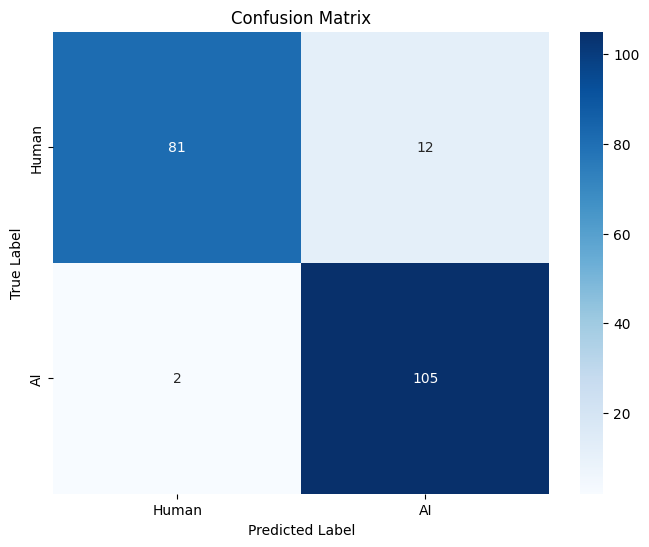

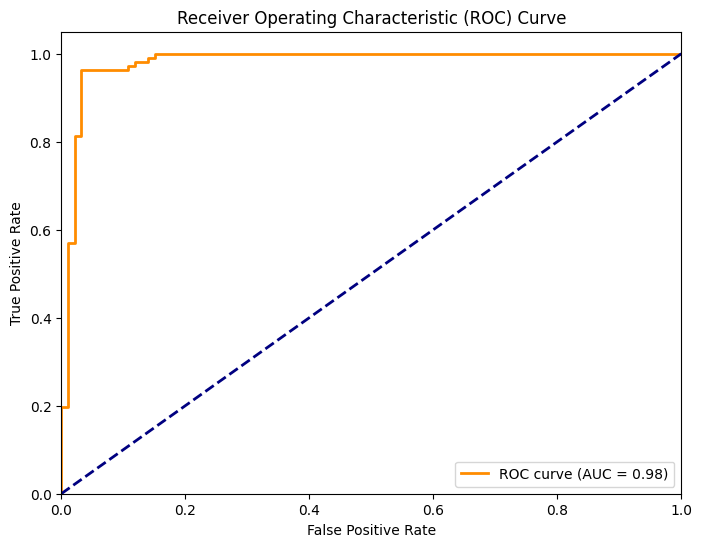

AUC: 0.9811


In [ ]:
# Load the existing model and metrics
model = joblib.load('bert_publication_metrics_model_regularized.pkl')
author_h_index, journal_impact_factor = joblib.load('publication_metrics_regularized.pkl')

# Load the test dataset
test_df = pd.read_csv('test_dataset.csv')

# Setup BERT model (reusing the existing function)
from transformers import BertTokenizer, BertModel, BertConfig

def setup_bert_model():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    config = BertConfig.from_pretrained('bert-base-uncased')
    config.hidden_dropout_prob = 0.3
    config.attention_probs_dropout_prob = 0.3
    model = BertModel.from_pretrained('bert-base-uncased', config=config)
    return tokenizer, model

def get_bert_embeddings(text, tokenizer, model, max_length=128):
    if pd.isna(text) or text == "":
        text = " "
    
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                      padding='max_length', truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']
    
    masked_states = last_hidden_states * attention_mask.unsqueeze(-1)
    summed = torch.sum(masked_states, dim=1)
    count = torch.sum(attention_mask, dim=1, keepdim=True)
    pooled_output = summed / count
    
    return pooled_output.numpy().flatten()

# Initialize BERT
tokenizer, bert_model = setup_bert_model()

# Extract features from test data
X_test = []
y_test = []

for idx, row in test_df.iterrows():
    # Extract text features
    text = row['Text'] if not pd.isna(row['Text']) else ""
    bert_features = get_bert_embeddings(text, tokenizer, bert_model)
    
    # Get publication metrics
    author = row['Published By'] if not pd.isna(row['Published By']) else ""
    journal = row['Journal Name'] if not pd.isna(row['Journal Name']) else ""
    
    h_index = author_h_index.get(author, 0)
    impact_factor = journal_impact_factor.get(journal, 1.0)
    
    # Additional features
    word_count = len(text.split()) if not pd.isna(text) else 0
    avg_word_length = np.mean([len(w) for w in text.split()]) if text else 0
    
    # Combine features
    combined_features = np.concatenate([
        bert_features,
        [h_index, impact_factor, word_count, avg_word_length]
    ])
    
    X_test.append(combined_features)
    y_test.append(row['Label'])

X_test = np.array(X_test)
y_test = np.array(y_test)

# Get predictions and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (AI-generated)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Human', 'AI'],
           yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"AUC: {roc_auc:.4f}")
